# Data Preprocessing

## Import packages
and define functions

In [1]:
%matplotlib inline

import numpy as np
import pydicom as dicom
import os
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from glob import glob
import scipy.ndimage
import re
from sklearn.model_selection import train_test_split

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def load_scan(path):
    #slices = [dicom.read_file((path + '/' + s) for s in os.listdir(path))]
    slices = []
    for file in glob(path + '/*.DCM'):
        slices.append(dicom.read_file(file))
    slices.sort(key = lambda x: int(x.InstanceNumber)) # sort by slice number
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def show_dcm_info(dataset, path):
    print("Filename.........:", path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    if 'ViewPosition' in dataset:
        print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=4, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    ind = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i,j].set_title('slice %d' % (ind+1))
            ax[i,j].imshow(stack[ind],cmap='gray')
            ax[i,j].axis('off')
            ind = ind + show_every
    plt.show()

## Define variables
Split the dataset into training and testing, then loop over all available patient data and save as npy files for later use

In [2]:
all_patients = next(os.walk('../data/Vertebrae'))[1]
print(all_patients)
print("Total of %d patients" %len(all_patients))

['E3822', 'E3670', 'E5119', 'E3420', 'E3429', 'E3623', 'E4634', 'E3815', 'E3027', 'E5145', 'E4635', 'E4407', 'E3622', 'E3625', 'E3394', 'E3994', 'E4746', 'E3570', 'E3579', 'E3374', 'E4619', 'E3654', 'E1900', 'E4024', 'E4689', 'E3049', 'E2907', 'E4451', 'E4809', 'E5125', 'E2964', 'E4492', 'E3015', 'E5093', 'E2610', 'E3962', 'E5021', 'E3110', 'E3544', 'E2692', 'E3572', 'E3377', 'E2604', 'E2914', 'E3062', 'E4849']
Total of 46 patients


Some patients do not have masks or data at all... (patients with ID of `E3374`,`E3570`,`E3062`) - remove these patients

In [3]:
all_patients = np.delete(all_patients, [i for i,item in enumerate(all_patients) if "E3374" in item])
all_patients = np.delete(all_patients, [i for i,item in enumerate(all_patients) if "E3570" in item])
all_patients = np.delete(all_patients, [i for i,item in enumerate(all_patients) if "E3062" in item])
#all_patients = all_patients[all_patients!='E3374']
print(all_patients)
print("Total of %d patients" %len(all_patients))

['E3822' 'E3670' 'E5119' 'E3420' 'E3429' 'E3623' 'E4634' 'E3815' 'E3027'
 'E5145' 'E4635' 'E4407' 'E3622' 'E3625' 'E3394' 'E3994' 'E4746' 'E3579'
 'E4619' 'E3654' 'E1900' 'E4024' 'E4689' 'E3049' 'E2907' 'E4451' 'E4809'
 'E5125' 'E2964' 'E4492' 'E3015' 'E5093' 'E2610' 'E3962' 'E5021' 'E3110'
 'E3544' 'E2692' 'E3572' 'E3377' 'E2604' 'E2914' 'E4849']
Total of 43 patients


In [4]:
X_train, X_test = train_test_split(
    all_patients, test_size=0.2, random_state=42)
print("Training data:", X_train)
print("Testing data:", X_test)

Training data: ['E3420' 'E4634' 'E5125' 'E5093' 'E3654' 'E3579' 'E3625' 'E2604' 'E3994'
 'E5145' 'E4746' 'E3015' 'E4809' 'E3822' 'E4492' 'E2914' 'E3623' 'E4407'
 'E2610' 'E3670' 'E4849' 'E4024' 'E5119' 'E3962' 'E3049' 'E3110' 'E4635'
 'E4689' 'E4619' 'E1900' 'E3815' 'E3394' 'E2964' 'E3572']
Testing data: ['E2692' 'E2907' 'E4451' 'E3544' 'E5021' 'E3377' 'E3429' 'E3622' 'E3027']


In [9]:
for n in X_train:
    PATIENT_ID = n
    IMG_TYPE = "01" #for water, "02" for fat, "10" for fat frac, "00" for r2*
    DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/*"+IMG_TYPE+"/"
    MASK_PATH = "../data/Vertebrae/"+PATIENT_ID+"/mask*/" # folders are either 'mask' or 'masks'
    OUTPUT_PATH = "./train/"
    #file = glob(DATA_PATH + '/*I1.DCM')
    #show_dcm_info(dicom.dcmread(file[0]),DATA_PATH)
    print("Processing patient ", n)
    patient = load_scan(DATA_PATH)
    imgs = get_pixels(patient)
    if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
        print("Patient %s doesn't have 20 slices" % n)
    else:
        np.save(OUTPUT_PATH + "imgs/fullimages_%s.npy" % (PATIENT_ID), imgs)
        patient_mask = load_scan(MASK_PATH)
        masks = get_pixels(patient_mask)
        #overlaid_imgs = np.multiply(masks,imgs)
        np.save(OUTPUT_PATH + "labels/fullimages_%s.npy" % (PATIENT_ID), masks)
    

Processing patient  E3420
Processing patient  E4634
Processing patient  E5125
Processing patient  E5093
Processing patient  E3654
Processing patient  E3579
Processing patient  E3625
Processing patient  E2604
Processing patient  E3994
Processing patient  E5145
Processing patient  E4746
Processing patient  E3015
Processing patient  E4809
Processing patient  E3822
Processing patient  E4492
Processing patient  E2914
Processing patient  E3623
Processing patient  E4407
Processing patient  E2610
Processing patient  E3670
Processing patient  E4849
Processing patient  E4024
Processing patient  E5119
Processing patient  E3962
Processing patient  E3049
Processing patient  E3110
Patient E3110 doesn't have 20 slices
Processing patient  E4635
Processing patient  E4689
Processing patient  E4619
Processing patient  E1900
Processing patient  E3815
Processing patient  E3394
Processing patient  E2964
Processing patient  E3572


In [11]:
for n in X_test:
    PATIENT_ID = n
    IMG_TYPE = "01" #for water, "02" for fat, "10" for fat frac, "00" for r2*
    DATA_PATH = "../data/Vertebrae/"+PATIENT_ID+"/*"+IMG_TYPE+"/"
    MASK_PATH = "../data/Vertebrae/"+PATIENT_ID+"/mask*/" # folders are either 'mask' or 'masks'
    OUTPUT_PATH = "./test/"
    #file = glob(DATA_PATH + '/*I1.DCM')
    #show_dcm_info(dicom.dcmread(file[0]),DATA_PATH)
    print("Processing patient ", n)
    patient = load_scan(DATA_PATH)
    imgs = get_pixels(patient)
    if (imgs.shape[0] != 20): # some patients don't have 20 slices acquired
        print("Patient %s doesn't have 20 slices" % n)
    else:
        np.save(OUTPUT_PATH + "imgs/fullimages_%s.npy" % (PATIENT_ID), imgs)
        patient_mask = load_scan(MASK_PATH)
        masks = get_pixels(patient_mask)
        #overlaid_imgs = np.multiply(masks,imgs)
        np.save(OUTPUT_PATH + "labels/fullimages_%s.npy" % (PATIENT_ID), masks)

Processing patient  E2692
Processing patient  E2907
Processing patient  E4451
Processing patient  E3544
Processing patient  E5021
Processing patient  E3377
Processing patient  E3429
Processing patient  E3622
Processing patient  E3027
Patient E3027 doesn't have 20 slices


## Prepare data for NN

In [12]:
import sys
import random
import warnings

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
NUM_SLICES = 20
IMG_CHANNELS = 1
TRAIN_PATH = './train/'
TEST_PATH = './test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [20]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH+'imgs/'))[2]
test_ids = next(os.walk(TEST_PATH+'imgs/'))[2]

# Get and resize train images and masks
X_train = np.zeros((len(train_ids), NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
y_train = np.zeros((len(train_ids), NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + 'imgs/' + id_
    img = np.load(path)[:,:,:,np.newaxis]
    #img = resize(img, (NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), mode='constant', preserve_range=True, anti_aliasing=True)
    X_train[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    path = TRAIN_PATH + 'labels/' + id_
    mask_ = np.load(path)[:,:,:,np.newaxis]
    #mask_ = resize(mask_, (NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True, anti_aliasing=True)
    mask = np.maximum(mask, mask_)
    y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
y_test = np.zeros((len(test_ids), NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + 'imgs/' + id_
    img = np.load(path)[:,:,:,np.newaxis]
    sizes_test.append([img.shape[0], img.shape[1]])
    #img = resize(img, (NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),clip=False, mode='constant', preserve_range=True, anti_aliasing=True)
    X_test[n] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    path = TEST_PATH + 'labels/' + id_
    mask_ = np.load(path)[:,:,:,np.newaxis]
    #mask_ = resize(mask_, (NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1),clip=False, mode='constant', preserve_range=True, anti_aliasing=True)
    mask = np.maximum(mask, mask_)
    y_test[n] = mask

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████| 33/33 [00:00<00:00, 92.46it/s] 

Getting and resizing test images ... 



100%|██████████| 8/8 [00:00<00:00, 48.70it/s]

Done!


In [21]:
# [0] is num of patients
# [1] is num of slices
# [2][3] are width/height
# [4] is num of channels
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(33, 20, 256, 256, 1)
(8, 20, 256, 256, 1)
(33, 20, 256, 256, 1)
(8, 20, 256, 256, 1)


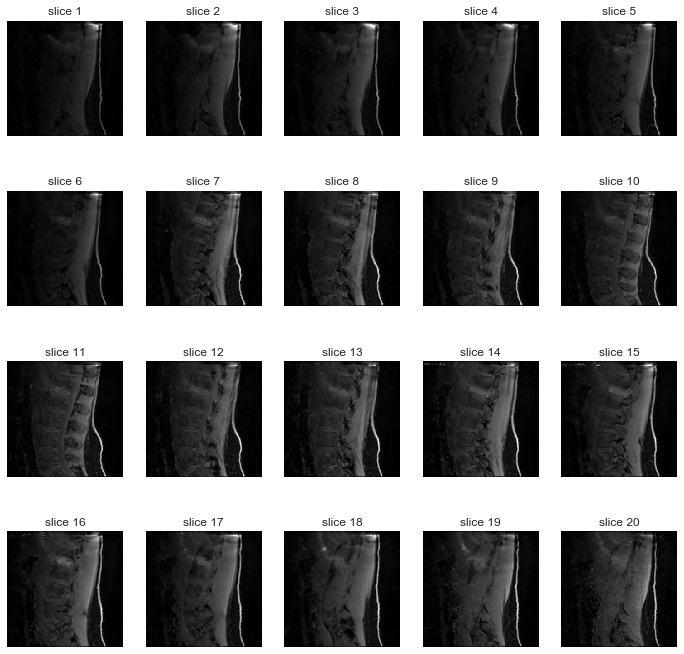

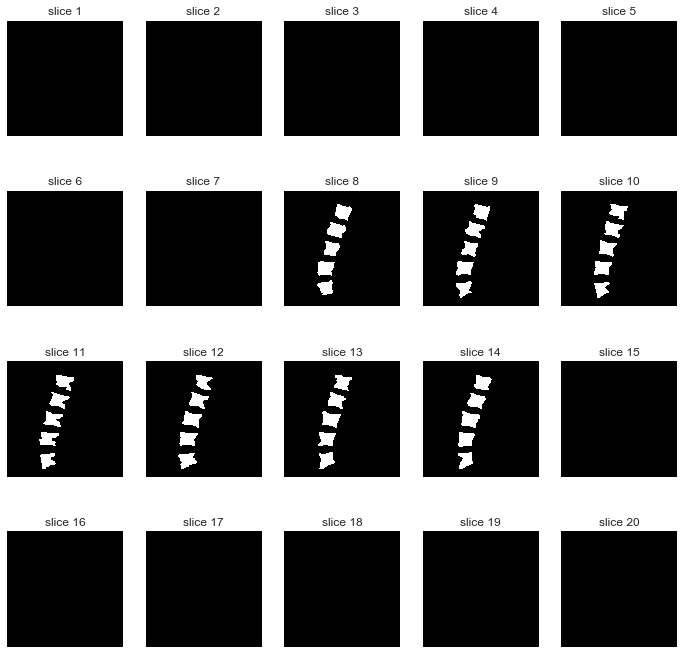

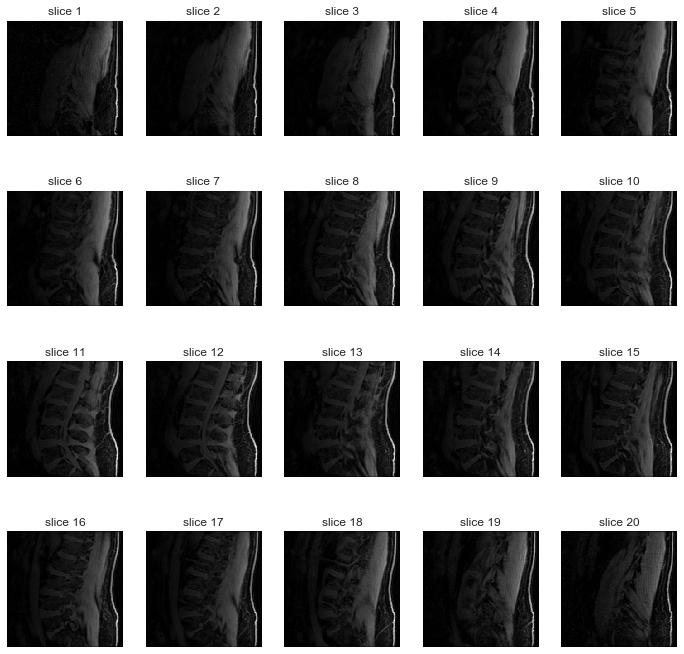

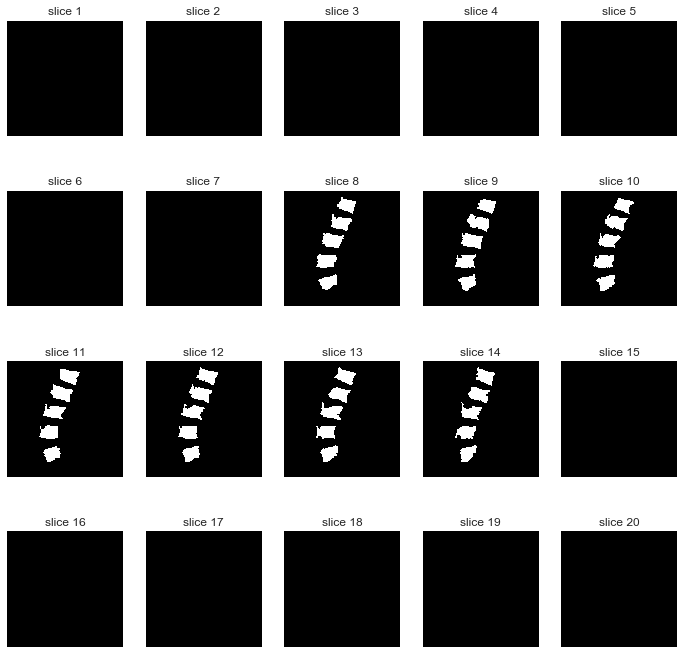

In [22]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
sample_stack(np.squeeze(X_train[ix]))
plt.show()
sample_stack(np.squeeze(y_train[ix]))
plt.show()

# Check if testign data looks all right
ix = random.randint(0, len(test_ids))
sample_stack(np.squeeze(X_test[ix]))
plt.show()
sample_stack(np.squeeze(y_test[ix]))
plt.show()

Images initially looked weird since `dtype=uint8` was used instead of `uint16`

Let's make a callable function that returns our training and testing data, and set up `data.py` script

In [4]:
import numpy as np
import pydicom as dicom
import os
from glob import glob
import scipy.ndimage
import re
import sys
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images

def natural_sort(l): 
    convert = lambda text: int(text) if text.isdigit() else text.lower() 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def load_scan(path):
    #slices = [dicom.read_file((path + '/' + s) for s in os.listdir(path))]
    slices = []
    for file in glob(path + '/*.DCM'):
        slices.append(dicom.read_file(file))
    slices.sort(key = lambda x: int(x.InstanceNumber)) # sort by slice number
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

def show_dcm_info(dataset, path):
    print("Filename.........:", path)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    if 'ViewPosition' in dataset:
        print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def get_pixels(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)
    
    return np.array(image, dtype=np.int16)

def sample_stack(stack, rows=4, cols=5, start_with=0, show_every=1):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    ind = start_with
    for i in range(rows):
        for j in range(cols):
            ax[i,j].set_title('slice %d' % (ind+1))
            ax[i,j].imshow(stack[ind],cmap='gray')
            ax[i,j].axis('off')
            ind = ind + show_every
    plt.show()

def get_data(TRAIN_PATH,TEST_PATH,IMG_WIDTH,IMG_HEIGHT,NUM_SLICES,IMG_CHANNELS):
    # Get train and test IDs
    train_ids = next(os.walk(TRAIN_PATH+'imgs/'))[2]
    test_ids = next(os.walk(TEST_PATH+'imgs/'))[2]

    # Get and resize train images and masks
    #print('Getting train images and masks ... ')
    X_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_train = np.zeros((len(train_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        i = 0
        path = TRAIN_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TRAIN_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_train[n*NUM_SLICES + i] = img[i]
            y_train[n*NUM_SLICES + i] = mask[i]
            i+=1

    # Get and resize test images
    #print('Getting test images and masks ... ')
    X_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint16)
    y_test = np.zeros((len(test_ids)*NUM_SLICES, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    sizes_test = []
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        i = 0
        path = TEST_PATH + 'imgs/' + id_
        img = np.load(path)[:,:,:,np.newaxis]
        sizes_test.append([img.shape[0], img.shape[1]])
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        maskpath = TEST_PATH + 'labels/' + id_
        mask_ = np.load(maskpath)[:,:,:,np.newaxis]
        mask = np.maximum(mask, mask_)
        for i in range(NUM_SLICES):
            X_test[n*NUM_SLICES + i] = img[i]
            y_test[n*NUM_SLICES + i] = mask[i]
            i+=1
    print('Done!')

    return (X_train, X_test, y_train, y_test)

In [5]:
# Parameters
width = 256
height = 256
slices = 20
channels = 1
trainpath = './train/'
testpath = './test/'

(X_train, X_test, y_train, y_test) = get_data(trainpath,testpath,width,height,slices,channels)

100%|██████████| 8/8 [00:00<00:00, 57.32it/s]

Done!


In [6]:
print(X_train.shape)
print(X_test.shape)

(660, 256, 256, 1)
(160, 256, 256, 1)
